# Python for Finance
## Assignment 1

### Team:
Dion Tiggelman (2821653)

Name Name (student number)

Name Name (student number)



### Modules

In [823]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from statsmodels.formula.api import ols
import statsmodels.api as sm
import scipy
import scipy.stats
import seaborn as sns
from scipy.stats.mstats import winsorize

### Exercise 1 Part A

* Below we read the 6 excel files we need for question 1. The sheet that we need is Consumer Credit, so that is specified in the code (in the first sheet the sheet name is Consumer credit).

In [824]:
comp1 = pd.read_excel('firm-level-complaints-data-2020-h1.xlsx', sheet_name = 'Consumer credit')
comp2 = pd.read_excel('firm-level-complaints-data-2020-h2.xlsx', sheet_name = 'Consumer Credit')
comp3 = pd.read_excel('firm-level-complaints-data-2021-h1.xlsx', sheet_name = 'Consumer Credit')
comp4 = pd.read_excel('firm-level-complaints-data-2021-h2.xlsx', sheet_name = 'Consumer Credit')
comp5 = pd.read_excel('firm-level-complaints-data-2022-h1.xlsx', sheet_name = 'Consumer Credit')
comp6 = pd.read_excel('firm-level-complaints-data-2022-h2.xlsx', sheet_name = 'Consumer Credit')

* The first step in merging and cleaning the data is to create a list where we combine all the different dataframes. This allows us to iterate through the dataframes in the list using a loop and number the dataframes using the `enumerate` function. We start the enumeration at 1 because we want the values in the 'time' column, which we add in the code line below, to go from 1 to 6. Inside the loop, a column named 'time' is added to each dataframe, and its values are based on the number provided by the enumeration. We use this approach for two reasons. Firstly, it makes it easy to add more dataframes as additional time periods arise; these can be loaded and added to the list of dataframes. Secondly, it simplifies the process of creating the 'time' column compared to when the data has already been merged.

* Furthermore, inside the loop, we ensure that all column names in the various dataframes are converted to lowercase. This is useful because the usage of uppercase letters in column names varies across the dataframes. By doing this, we can easily merge columns with the same name.


In [825]:
dataframes = [comp1, comp2, comp3, comp4, comp5, comp6]

for i, df in enumerate(dataframes, start=1):
    df['time'] = i
    df.columns = df.columns.str.lower()

* In this code, we are merging all the dataframes that we've added to the list called 'dataframes' into a single dataframe using the `pd.concat` function. The default behavior of this function is to merge dataframes based on rows, which is exactly what we want, so there's no need to modify this. We also specify that the index should be reset by using `ignore_index=True`. Otherwise, the resulting dataframe would retain the index from each individual dataframe.

In [826]:
complaints = pd.concat(dataframes, ignore_index=True)

* The second line of code filters the rows in the complaints dataframe to keep only the rows where the 'reporting frequency' column is equal to 'Half Yearly' by using a boolean condition. This results in a new dataframe containing only the rows with 'Half Yearly' reporting frequency. Additionally, we reset the index here once more to ensure it is adjusted after rows have been removed from the dataframe.

In [827]:
complaints = complaints[complaints['reporting frequency'] == 'Half Yearly'].reset_index(drop=True)

* In the following step, we replace the 'NO GROUP' values in the 'firm group' and 'group' columns with NaN by using `replace` and `np.nan`. We do this to ensure that in the next step, when we combine these columns, these values will be treated as missing values.

In [828]:
complaints[['firm group', 'group']] = complaints[['firm group', 'group']].replace('NO GROUP', np.nan)

* The first line of code assigns the values from the 'group' column to the 'firm group' column in cases where the 'firm group' column has missing values. It fills missing 'firm group' values with values from the 'group' column.
* The second line of code uses the same method as the first line, but here it fills the remaining missing 'firm group values with 'firm name' values.
* The third line of code creates a new column 'id' in the complaints dataframe. It first converts the 'firm group' column into a categorical variable using `pd.Categorical` and then it assigns integer codes to each unique category.

In [829]:
complaints['firm group']= complaints['firm group'].combine_first(complaints['group'])
complaints['firm group']= complaints['firm group'].combine_first(complaints['firm name'])
complaints['id'] = pd.Categorical(complaints['firm group']).codes

* We discovered certain rows in the dataframe where both 'percentage upheld' and 'complaints upheld by firm' columns had missing values. Since we cannot perform analysis with these incomplete rows, they are removed using the `dropna` function. This function is applied to a subset of the dataframe containing these two columns. We specify `how='all'` to ensure that only the rows with no values in both columns are dropped. Again we reset the index after dropping rows.
* To ensure correct weighting of the 'percentage upheld' when we group the data by 'firm group,' the first step is to fill in the 'complaints upheld by firm' column for each row. We achieve this by filling the rows with missing values using the product of 'percentage upheld' and 'complaints received.'
* Now, we can start grouping all the data based on the 'id' column. We do this by first using the `groupby` function. We specify `as_index=False`, because we want to retain the index, and we don't want 'id' and 'time' to become the index. Then, we use the `agg` function to aggregate the three variables we want to add, while taking the 'sum' of the rows.
* In the final part of the code below, we have the total 'complaints upheld' and 'complaints received' by a firm group, which is identified by 'id.' This allows us to accurately calculate the 'percentage upheld' by dividing 'complaints upheld by firm' by 'complaints received.'

In [830]:
complaints.dropna(subset=['percentage upheld', 'complaints upheld by firm'], how='all', inplace=True)
complaints.reset_index(drop=True, inplace=True)

complaints['complaints upheld by firm'] = complaints['complaints upheld by firm'].fillna(complaints['percentage upheld'] * complaints['complaints received'])

complaints = complaints.groupby(['id', 'time'],as_index=False).agg({'complaints received':'sum', 'complaints closed':'sum', 'complaints upheld by firm':'sum'})

complaints['percentage upheld'] = complaints1['complaints upheld by firm'] / complaints1['complaints received']

* Below, we remove the column that is no longer needed for the rest of the exercise using the Pandas drop function. We specify axis=1 because we want the removal to be performed along the columns.

In [831]:
complaints = complaints.drop(['complaints upheld by firm'] , axis=1)

* Subsequently, we change the data type of the 'id' column from int16 to int64 to match the data types shown in the exercise. We then verify this by using the `dtypes` function, and it matches as expected.

In [832]:
complaints['id'] = complaints['id'].astype('int64')
complaints.dtypes

id                       int64
time                     int64
complaints received      int64
complaints closed        int64
percentage upheld      float64
dtype: object

### Exercise 1 Part B

* To plot this, we first need to group the complaints data based on the 'time' column and then add the 'percentage upheld' column to it. Then we can perform the aggregation operations using the created object, which in this case includes calculating the median, 25th quantile, and 75th quantile (over time).
* After that, we proceed to create the plot using the plt package. First, we determine the figure size with figsize. Then, we plot the three lines for the median, q25, and q75, labeling each line and specifying different markers and line styles. We also provide suitable names for the x-axis and y-axis and add a title to the plot. We include a legend with labels that we assigned during the line plotting. Finally, we set `ax.grid(True)` to make the plot easier to read.
* The plot reveals that there are some changes over time, showing a slight downward trend. Even though the values for periods 1 and 6 don't differ significantly for all three lines, the trend indicates a subtle shift in the data over time.

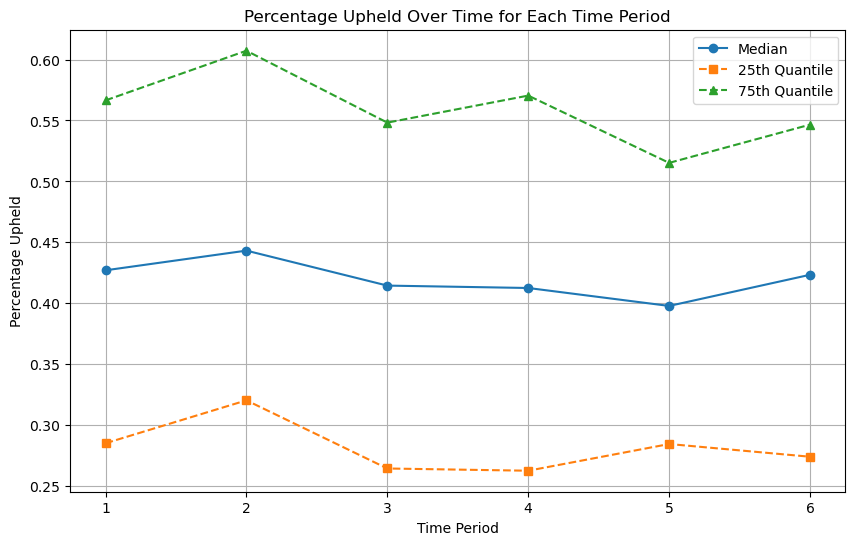

In [833]:
upheld_time = complaints.groupby('time')['percentage upheld']
median = upheld_time.median()
q25 = upheld_time.quantile(0.25)
q75 = upheld_time.quantile(0.75)

fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(median, label='Median', marker='o', linestyle='-')
ax.plot(q25, label='25th Quantile', marker='s', linestyle='--')
ax.plot(q75, label='75th Quantile', marker='^', linestyle='--')
ax.set_xlabel('Time Period')
ax.set_ylabel('Percentage Upheld')
ax.set_title('Percentage Upheld Over Time for Each Time Period')
ax.legend()
ax.grid(True)

* To calculate the mean of the 'percentage upheld' over time, grouped by 'firm group,' we once again use the `groupby` function. This time, we group based on the 'id' column and include the 'percentage upheld' column to calculate the mean of this data. By doing this, we obtain the mean of 'percentage upheld' of the various time periods for each firm group.
* After that, we create a plot again using the `plt` package. In this case, we opt to plot a histogram, and within the `hist` function, we specify various settings. For example, we set the number of bins, in this case, 40. We also specify the edgecolor to enhance the visibility of the histogram. Here We also add labels for the y-axis, x-axis, and a title to the plot.
* The plot in the figure does tend to resemble a normal distribution, albeit with a slight right skew. This is because the mean is approximately around 0.43, causing a bit more data to be concentrated on the left side of the center.

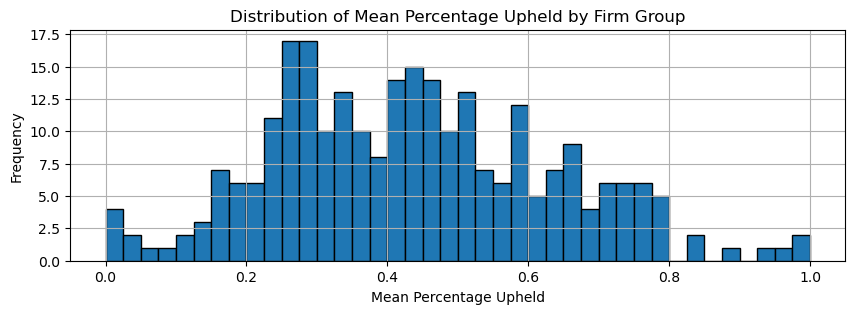

In [834]:
upheld_group = complaints.groupby('id').agg({'percentage upheld':'mean'})

fig, ax = plt.subplots(figsize=(10, 3))
ax.hist(upheld_group, bins=40, edgecolor='k')
ax.set_title('Distribution of Mean Percentage Upheld by Firm Group')
ax.set_xlabel('Mean Percentage Upheld')
ax.set_ylabel('Frequency')
ax.grid(True)

* In this part we use the same data as in previous task, only we add the variable complaints closed by using the `agg` function. We add the sum of the complaints closed. 
* We found one period for one 'id' that had a value of 0 for 'complaints closed'. This makes it difficult to take the logarithm and run the regression. Because it is only one time period for one firm group, we decided to delete this row by filtering the dataset to rows where the complaints closed is not 0.
* After this we can compute the log complaints closed variable by using the `np.log10` function.
* Now, we can start the regression. First we assign the variables to Y and X, so that we can easily put this in our OLS regression. When we have done this we do the OLS regression by using the `ols` function, setting Y (log complaints upheld) and X (percentage upheld) and adding the data. Then we store the estimates of the model and print them on screen.
* In the results we see that there is a negative relation between the percentage upheld and the log complaints closed. However if we look to the t-statistic the parameter for percentage upheld is not significant with a 95% confidence level. This means we cannot reject the 0 hypothesis that the parameter is significantly different from zero and it implies that (with a confidence level of 95%) the percentage of complaints upheld not predicts the log number of complaints that are closed.

In [835]:
upheld_group2 = complaints.groupby('id').agg({'percentage upheld':'mean', 'complaints closed': 'sum'})

upheld_group2 = upheld_group2[upheld_group2['complaints closed'] != 0]

upheld_group2['log compplaints closed'] = np.log10(upheld_group2['complaints closed'])

Y = upheld_group2['log compplaints closed']
X = upheld_group2['percentage upheld']

model = ols('Y ~ X', upheld_group2)
estimates1 = model.fit()

print(estimates1.summary())

                            OLS Regression Results                            
Dep. Variable:                      Y   R-squared:                       0.011
Model:                            OLS   Adj. R-squared:                  0.007
Method:                 Least Squares   F-statistic:                     2.903
Date:                Mon, 25 Sep 2023   Prob (F-statistic):             0.0896
Time:                        17:06:21   Log-Likelihood:                -386.09
No. Observations:                 263   AIC:                             776.2
Df Residuals:                     261   BIC:                             783.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      3.3938      0.157     21.632      0.0

#### Additional statistical analysis

* In the first step of the additional statistical analysis, we start by generating a summary statistics table using the `describe` function. Within this table we already see some interesting things and potential outliers. For instance, the maximum value of 'percentage upheld' appears to be illogical, as it should not exceed 1 since it represents a percentage. Additionally, the maximum values of 'complaints received' and 'complaints closed' are considerably higher in relation to the various quantiles. When conducting further analyses and creating plots involving these variables, we need to take those outliers in consideration and deal with them.

In [836]:
complaints.describe()

,id,time,complaints received,complaints closed,percentage upheld
count,695.000000,695.000000,695.000000,695.000000,695.000000
mean,128.523741,3.466187,3304.542446,3264.161151,0.433280
std,76.174676,1.729951,6196.119598,6092.449519,0.219025
min,0.000000,1.000000,1.000000,0.000000,0.000000
25%,61.000000,2.000000,281.500000,279.500000,0.280855
50%,128.000000,3.000000,1059.000000,1025.000000,0.423077
75%,190.000000,5.000000,3140.500000,3142.000000,0.566823
max,265.000000,6.000000,63158.000000,63214.000000,2.000000


* When we create a box plot for the percentage upheld for each time period using the `sns` package, we once again encounter these outliers. The trend over time resembles the plot we previously generated in this assignment, but hrough this plot, the presence of outliers in the data becomes more clear.

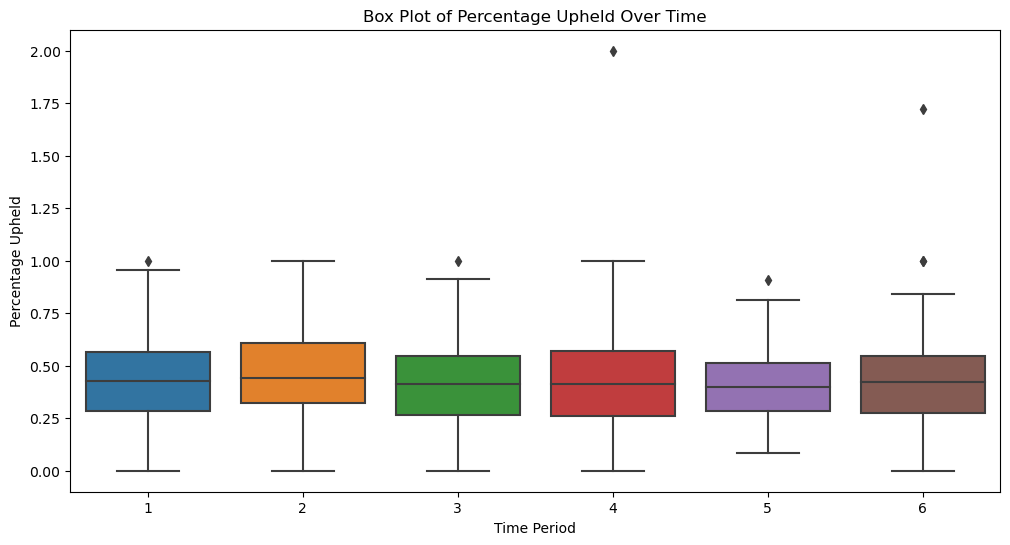

In [837]:
fig, ax = plt.subplots(figsize=(12, 6))
sns.boxplot(data=complaints, x='time', y='percentage upheld')
ax.set_title('Box Plot of Percentage Upheld Over Time')
ax.set_xlabel('Time Period')
ax.set_ylabel('Percentage Upheld')
plt.show()

* To deal with these outliers, we use the `winsorize` function from the `scipy.stats.mstats package`. In this process, we need to establish thresholds for winsorization. The outliers are present only on the upper end, so we only need to determine an upper threshold. Given that there are relatively few outliers in this data, we set the upper threshold to 0.005. After that we replace the 'percentage upheld' variable with the winsorize version.

In [838]:
wins_percentage_upheld = winsorize(complaints['percentage upheld'], limits=(0 , 0.005))

complaints['percentage upheld'] = wins_percentage_upheld

* Now we can plot the boxplots again. We see that without the outliers it looks a lot better. If we would perform another regression the outliers wouldn't negatively affect the slope anymore.


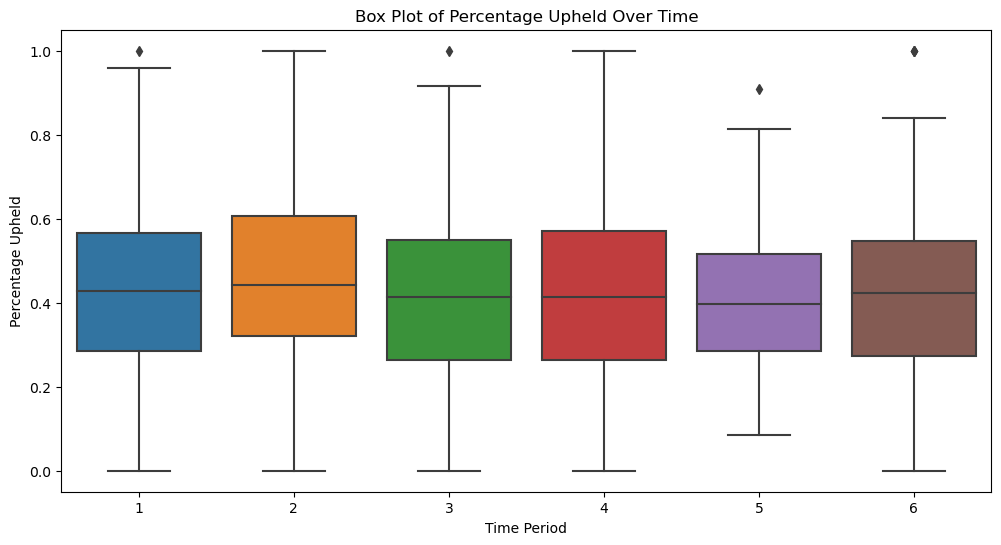

In [839]:
fig, ax = plt.subplots(figsize=(12, 6))
sns.boxplot(data=complaints, x='time', y='percentage upheld')
ax.set_title('Box Plot of Percentage Upheld Over Time')
ax.set_xlabel('Time Period')
ax.set_ylabel('Percentage Upheld')
plt.show()

### Exercise 2

In [854]:
crsp = pd.read_csv('xrerfphrinihp8jn.csv')

#### Filtering & cleaning the data

* In order to properly use the data we need to filter out the useble data and clean up unusable data from the data set. We started by checking for non-numeric values in the return column. Accoridng to the CRSP data guide, provided in the lecture videos, unusable data in the RET column ara marked down with the values 'B', 'C', '-66.0', '-77.0' or '-99.0'. The code below counts the number of cells in the RET column with for each of the stated values. Thereafter we replace these values, if they have been found in the data set, with the NaN (not a number) value. This allows us to convert the data under the RET column to floating numbers, which is done in the next line[7] of code.

In [855]:
print(sum(crsp.RET=='B'),sum(crsp.RET=='C'),sum(crsp.RET=='-66.0'),sum(crsp.RET=='-77.0'),sum(crsp.RET =='-99.0'))

35 27 0 0 0


In [856]:
crsp['RET'].replace(['C','B'],np.NaN,inplace=True)

In [857]:
print(sum(crsp.RET == 'B'),sum(crsp.RET == 'C'))

0 0


In [858]:
crsp['RET'] = pd.to_numeric(crsp['RET'],downcast='float')

In [859]:
crsp.dtypes

PERMNO      int64
date        int64
EXCHCD    float64
TICKER     object
COMNAM     object
PERMCO      int64
CUSIP      object
PRC       float64
RET       float32
vwretd    float64
sprtrn    float64
dtype: object

#### Number of months

* In order to filter out the stocks that are not present in the data set for all monthes we first count the number of total months over the whole time period. We do this by creating a variable called tot months which contains all unique dates in the data set. Here after we check the length of the variable 'totmonths' which givess us the number of uniqe dates, and thus the total amount of months. 


In [860]:
totmonths= crsp.date.unique()
nm=len(totmonths)
nm

216

* Here we duplicate the dataset for us to keep the orriginal data, if we need it later. 
* We add a variable 'months' to the unique data with a value of 1 for all rows. 
* here after we group buy 'TICKER', and sum all numeric variables, and we save this in a new dataframe named 'a'.

In [861]:
crsp2=crsp
crsp2['months']=1
a= crsp2.groupby(crsp2.TICKER).sum(numeric_only = True)

* we create a new dataframe named 'cm', which only includes data with a sum of months (number of months), equal to the total number of months over the complete time frame. This creates a datafram that only includes stocks that are present in the data set for all months. 

In [862]:
cm = a[a.months==nm]

* After this we store all the 'TICKER' values in under 'comp_firms' which have been included in data frame 'cm', which gives us all companies that should be included in the data frame that we will use for our analysis. 

In [863]:
comp_firms=cm.index.values[cm.months == nm]

* Finally, we create a new data frame that includes data from the orriginal data frame 'crsp' for the stocks included in 'comp_firms', we name this new data frame 'crsp3'. This gives us a complete data set of all firms with data for the whole time period.

In [864]:
crsp3= crsp[crsp.TICKER.isin(comp_firms)]

#### Cumulative returns

* In the 'crsp3' dataframe we create a new column 'RET+1', which will be used to calculate cumulative returns. The code to do this gave us an error, which could be fixed by the code in the next line, whereafter we were able to create a new colum with the values from the 'RET' column plus 1.

In [865]:
pd.options.mode.chained_assignment = None

In [866]:
crsp3['RET+1'] = crsp3['RET'] + 1

* The code below creates a new column, named 'Cumulative_Return' with cumulative returns for every month from the start month up until the last month of the dataset. We need to use the groupby command and group by 'TICKER' so the cumulative return column is linked to the specifick stocks. Furthermore we add "['RET+1'].cumprod()" which lets us cumulate the return+1 values for all months for each ticker. 

In [867]:
crsp3['Cumulative_Return'] = crsp3.groupby('TICKER')['RET+1'].cumprod()

#### Date time variables

* In the code below we create format the date variable to be a date-time variable instead of a integer. We had to added the part ".astype(str)" to first make a string out of the date variable, for the code to work. The format that we chose is YYYY-MM-DD.

In [868]:
crsp3.date = pd.to_datetime(crsp3['date'].astype(str), format='%Y%m%d')

#### Finding the top performing stocks in 2001

* after creating date-time variables we could easily filter the data from 2001 and place this in a new data frame, named 'year_2001'.

In [870]:
year_2001 = crsp3[crsp3['date'].dt.year == 2001]

* In the code below we gather all values of 'Cumulative_Return' for the last month of 2001, this is done by adding ".last()" to the code. We store these values under 'dec2001_cumr'.

In [871]:
dec2001_cumr = year_2001.groupby('TICKER')['Cumulative_Return'].last()

* Now we can sort all values in 'dec2001_cumr' from high to low using (ascending=False), and filter on the 10 highest valuess by using ".index.values[:10]". Then we store these 10 highest values as 'best10_2001' 

In [872]:
best10_2001 = dec2001_cumr.sort_values(ascending=False).index.values[:10]

* Below the tickers of the 10 best performing stocks of 2001 can be found.

In [873]:
best10_2001

array(['NVDA', 'ATVI', 'WDC', 'EBAY', 'SYMC', 'ROST', 'MCHP', 'LRCX',
       'GILD', 'HAS'], dtype=object)

#### creating a data frame for dates between 2002 and 2018

* Here we filter data to have dates between january 2002 and december 2018, save the filtered data as 'crsp3_2002_2018'
* Then we drop the cumulative return column, because 2001 was included in these values, and we create a new cululative return column with data starting in 2002.

In [875]:
crsp3_2002_2018=crsp3[(crsp3['date']>= '2002-01-01') & (crsp3['date']<= '2018-12-31')]

crsp3_2002_2018 = crsp3_2002_2018.drop(columns=['Cumulative_Return'])
crsp3_2002_2018['Cum_Return_02'] = crsp3_2002_2018.groupby('TICKER')['RET+1'].cumprod()

#### Creating a data frame for december

Here we make a new data frame for only the last mont of 2018

In [877]:
crsp3_2002_2018['year']=crsp3_2002_2018['date'].dt.year
crsp3_2002_2018['month']=crsp3_2002_2018['date'].dt.month

* filter the data from dataframe 'crsp3_2002_2018' to only include data for December 2018. This wil allow us to directly find the cumulative return of for the last month of the investment period data from the dataframe 'crsp3_2002_2018'

In [878]:
december_2018_cum = crsp3_2002_2018[crsp3_2002_2018['date'].dt.year == 2018]
december_2018_cum = december_2018_cum[december_2018_cum['date'].dt.month == 12]

* create an empty list and loop to check for all of the 10 stocks in 'best10_2001' what their cumulative return was in december 2018. 

In [879]:
cumulative_returns = {}
for ticker in best10_2001:
    if ticker in december_2018_cum['TICKER'].values:
        ticker_data = december_2018_cum[december_2018_cum['TICKER'] == ticker]
        cumulative_return = ticker_data['Cum_Return_02'] 
        cumulative_returns[ticker] = cumulative_return.values

Calculate the investment value for each ticker

In [880]:

investment_value = (15000 / 10)  
Val_2001inv_in2018 = {ticker: investment_value*cumulative_return for ticker, cumulative_return in cumulative_returns.items()}


In [881]:
total_investment_value_2001 = sum(Val_2001inv_in2018.values())


print(total_investment_value_2001)

[143447.78]


#### total value of invesstmentt from 2001

The code above gives us the total value of the investment from 2001 in the top 10 stocks from 2001, which has a value of 143447.78 dollar

#### Finding the top 2 stocks for each month

* Here we make new data frame which groups the data on month and year, and gives the 2 highest return values for every group, whit is done by adding '['RET'].nlargest(2)' at the end of the string.
* Then we index the top two in the two best performing stocks and save this index as 'top2_index'

In [882]:
top_2_per_month=crsp3_2002_2018.groupby(['year', 'month'])['RET'].nlargest(2)

top2_index = top_2_per_month.index.levels[2]

* Here after we make a data frame named 'top_return_df', which includes 'year', 'month', 'date', 'TICKER' and 'RET', found in crsp3_2002_2018 for all index values from top2_index.
* then we sort the values by dates and store this as a new data frame named 'top_return_sorted_date'

In [883]:
top_return_df = crsp3_2002_2018.loc[top2_index, ['year', 'month', 'date', 'TICKER', 'RET']]

top_return_sorted_date = top_return_df.sort_values(by='date')